# Madrid Housing Prices Analysis

Data on flats from https://www.kaggle.com/datasets/mirbektoktogaraev/madrid-real-estate-market/data

Location data from API (for neighborhoods and streets): https://here.com (geocoding)

## Initialization (aquiring data)

In [15]:
import pandas as pd
import geopandas as gpd
import json
import folium

In [16]:
# Load data
df_houses = pd.read_csv('houses_Madrid.csv')

df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    21742 non-null  int64  
 1   id                            21742 non-null  int64  
 2   title                         21742 non-null  object 
 3   subtitle                      21742 non-null  object 
 4   sq_mt_built                   21616 non-null  float64
 5   sq_mt_useful                  8228 non-null   float64
 6   n_rooms                       21742 non-null  int64  
 7   n_bathrooms                   21726 non-null  float64
 8   n_floors                      1437 non-null   float64
 9   sq_mt_allotment               1432 non-null   float64
 10  latitude                      0 non-null      float64
 11  longitude                     0 non-null      float64
 12  raw_address                   16277 non-null  object 
 13  i

In [17]:
# Load locations that we got from an API
neighborhood_locations = {}

with open("saved_locations.json", "r") as f:
    neighborhood_locations = json.load(f)
    
street_locations = {}
with open("street_locations_UT.json", 'r') as f:
    street_locations = json.load(f)

## Data analysis and visualization

In [18]:
import matplotlib.pyplot as plt

<Axes: xlabel='n_rooms'>

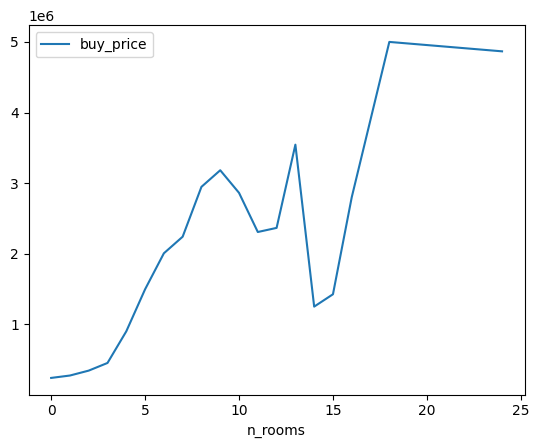

In [19]:
# Price VS number of rooms
nroom_group = df_houses.groupby('n_rooms')

nroom_group['buy_price'].mean().plot(legend=True)

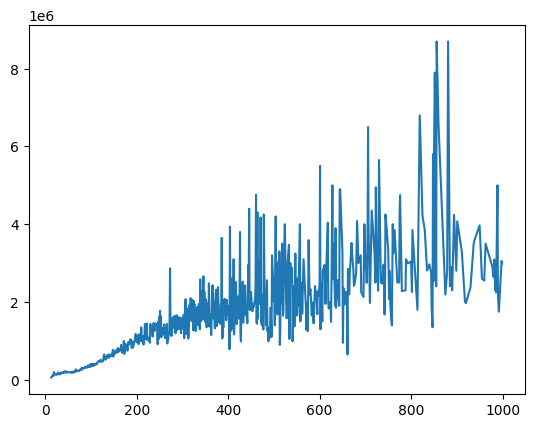

In [20]:
# Price VS Area
group_areas = df_houses.groupby('sq_mt_built')

plt.plot(group_areas['buy_price'].mean())

<Axes: xlabel='neighborhood_id'>

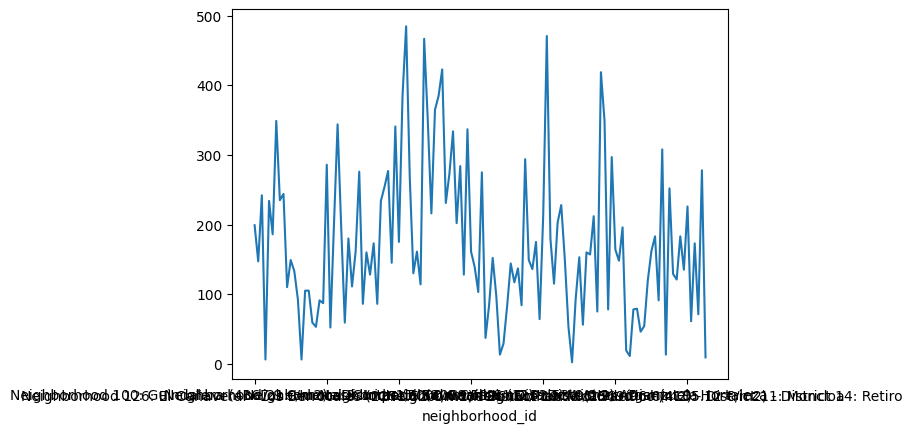

In [21]:
# Number of rows VS neighborhood ids
neighborhood_group = df_houses.groupby('neighborhood_id')

nhg_sizes = neighborhood_group.size()
nhg_sizes.plot()

In [22]:
# Min price and max price (for visualizations)

min_price = df_houses['buy_price'].min()
max_price = df_houses['buy_price'].max()

### Visualizing street data

In [23]:
# Initialize map
m = folium.Map(location=[40.37654, -3.60837], zoom_start=9.5)

In [24]:
import colorsys

In [25]:
def plot_dot(map: folium.Map, lat: float, lng: float, **kwargs):
    rad = kwargs.get('radius')
    weight = kwargs.get('weight')
    color = kwargs.get('color')
    
    folium.CircleMarker(location=[lat, lng],
                        radius=rad if rad is not None else 1,
                        weight=weight if weight is not None else 3,
                        color=color if color is not None else "#3388FF").add_to(map)

def rgb_to_hexstr(r: int, g: int, b: int) -> str:
    r = (r if r >= 0 else 0) if r <= 255 else 255
    g = (g if g >= 0 else 0) if g <= 255 else 255
    b = (b if b >= 0 else 0) if b <= 255 else 255
    return f'#{r:02x}{g:02x}{b:02x}'

def mapf(n: float, min1: float, max1: float, min2: float, max2: float) -> float:
    return ((n - min1) / (max1 - min1)) * (max2 - min2) + min2

In [26]:
# TODO: Process data and add to map
for street in street_locations.values():
    data = df_houses.iloc[street['idx']]
    mapped_price = mapf(data['buy_price'], min_price, max_price, 0.0, 1.0) ** 0.3
    color = [int(c * 255) for c in colorsys.hsv_to_rgb(0.3, 1.0, mapped_price)]
    plot_dot(m, street['loc']['lat'], street['loc']['lng'], radius=2, weight=4, color=rgb_to_hexstr(color[0], color[1], color[2]))

In [27]:
gdf_districts = gpd.GeoDataFrame.from_file("discrict_info/Barrios.shp")

In [28]:
ENABLE_DISTRICTS = False

if ENABLE_DISTRICTS:
    choropleth = folium.Choropleth(
        geo_data = gdf_districts,
        data = None,
        columns = ['COD_BAR', 'prices'],
        key_on = 'features.properties.COD_BAR',
        fill_opacity = 0.7,
        fill_color = 'Greens',
        name = 'Prices',
        line_opacity = 1.0,
        line_weight = 2.0,
        legend_name = "Neighborhood average prices",
        smooth_factor = 0.0
    ).add_to(m)

In [29]:
m